In [806]:
# Imports
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
import time
import pywt # For CWT

# Custom functions
import dataload
import transform

In [630]:
# Settings

all_names = [
    'ADGU101504',
    'ALUR012904',
    'BECA011405',
    'BRCA062405',
    'BRLO041102',
    'BTOL083105',
    'BTOL090105',
    'CAPO092605',
    'CRCA020205',
    'ESCI031905',
    'TAGO061203']

path_rec = "ssdata/register/"
rec_postamble = ".rec"

path_marks = "ssdata/label/marks/"
marks_preamble = "FixedSS_"
marks_postamble = ".txt"

path_states = "ssdata/label/states/"
states_preamble = "StagesOnly_"
states_postamble = ".txt"

params = {
    'channel': 1,             # Channel to be used
    'dur_epoch': 30,          # Time of window page [s]
    'n2_val': 3,              # N2 state coding value
    'context': 1.28,          # Length of context for timestep, in [s]
    'factor_border': 1,
    # spectrogram will be computed in a segment of length (factor_border+1)*context to avoid border effects
    'mark_smooth': 1,          # Number of samples to average at the center to get the segment central mark.
    'percentil': 99   # percentil for clipping
}

In [631]:
# Load database
data_list = []
start = time.time()
for i in range(len(all_names)):
    # Read EEG Signal
    path_edf_file = path_rec + all_names[i] + rec_postamble
    signal, fs = dataload.read_eeg(path_edf_file, params['channel'])
    # Read Expert marks
    path_marks_file = path_marks + marks_preamble + all_names[i] + marks_postamble
    marks = dataload.read_marks(path_marks_file, params['channel'])
    marks = transform.inter2seq(marks, 0, len(signal) - 1) # make 0/1
    # Read states
    path_states_file = path_states + states_preamble + all_names[i] + states_postamble
    states = dataload.read_states(path_states_file)
    # Find n2 epochs (individually)
    n2_epochs = np.where(states == params['n2_val'])[0]
    # Drop first and last epoch of the whole registers if they where selected
    last_state = states.shape[0] - 1
    n2_epochs = n2_epochs[(n2_epochs!=0) & (n2_epochs!=last_state)]
    # Clip-Normalize eeg signal
    epoch_size = params['dur_epoch'] * fs
    n2_list = []
    for epoch in n2_epochs:
        sample_start = epoch * epoch_size
        sample_end = (epoch+1) * epoch_size
        n2_signal = signal[sample_start:sample_end]
        n2_list.append(n2_signal)
    n2_signal = np.concatenate(n2_list, axis=0)
    
    data = n2_signal
    thr = np.percentile(np.abs(data), params['percentil'])
    data[np.abs(data) > thr] = float('nan')
    data_mean = np.nanmean(data)
    data_std = np.nanstd(data)
    
    signal = (np.clip(signal, -thr, thr) - data_mean) / data_std
    
    # Save data
    ind_dict = {'signal': np.array(signal),
                'epochs': np.array(n2_epochs),
                'marks': np.array(marks)}
    data_list.append(ind_dict)
    print('Subject '+str(i)+' Ready, Time: ' + str(time.time() - start) + ' [s]')
params['fs'] = fs           # Save sampling frequency [Hz]

print(len(data_list), ' records have been read.')
print('Sampling Frequency: ', fs, 'Hz')
print('Total Time: ' + str(time.time() - start) + ' [s]')

Subject 0 Ready, Time: 0.31916379928588867 [s]
Subject 1 Ready, Time: 0.6849675178527832 [s]
Subject 2 Ready, Time: 0.9973738193511963 [s]
Subject 3 Ready, Time: 1.3459422588348389 [s]
Subject 4 Ready, Time: 1.6608328819274902 [s]
Subject 5 Ready, Time: 1.829869270324707 [s]
Subject 6 Ready, Time: 1.985527515411377 [s]
Subject 7 Ready, Time: 2.3545656204223633 [s]
Subject 8 Ready, Time: 2.753218173980713 [s]
Subject 9 Ready, Time: 2.9386367797851562 [s]
Subject 10 Ready, Time: 3.2949836254119873 [s]
11  records have been read.
Sampling Frequency:  200 Hz
Total Time: 3.295219659805298 [s]


In [641]:
# Split train, val, test
n_reg = len(data_list)
reg_idx = np.arange(n_reg)
print(reg_idx)
np.random.shuffle(reg_idx)
print(reg_idx)

test_idx = reg_idx[0:2]
val_idx = reg_idx[2:4]
train_idx = reg_idx[4:n_reg]

print(test_idx)
print(val_idx)
print(train_idx)

[ 0  1  2  3  4  5  6  7  8  9 10]
[ 3  0 10  5  2  9  8  7  6  1  4]
[3 0]
[10  5]
[2 9 8 7 6 1 4]


In [642]:
# print data proportions for each register
mean_fraction = 0
for ind in range(len(data_list)):
    marks = data_list[ind]['marks']
    n_timestep_1 = sum(marks)
    n_epochs = len(data_list[ind]['epochs'])
    n_timestep_all = n_epochs*params['dur_epoch']*params['fs']
    fraction = n_timestep_1/n_timestep_all
    print('For register '+str(ind)+' we have fraction '+str(fraction))
    mean_fraction += fraction
mean_fraction /= len(data_list)
print('Mean fraction: '+str(mean_fraction))

For register 0 we have fraction 0.30535313531353137
For register 1 we have fraction 0.22453297682709447
For register 2 we have fraction 0.03903722943722944
For register 3 we have fraction 0.12060126984126984
For register 4 we have fraction 0.11847467771639042
For register 5 we have fraction 0.13248367346938775
For register 6 we have fraction 0.13614039408866996
For register 7 we have fraction 0.13689947780678852
For register 8 we have fraction 0.12489457202505219
For register 9 we have fraction 0.10953121693121694
For register 10 we have fraction 0.1298815663801337
Mean fraction: 0.1434391081669786


In [775]:
def sample_minibatch(batch_size=64, mode=None):
    global data_list # this will be a class attribute later
    global test_idx, val_idx, train_idx # this will be a class attribute later
    global params  # this will be a class attribute later
    segment_size = (params['factor_border'] + 1) * params['context'] * params['fs'] # static
    epoch_size = params['dur_epoch'] * params['fs'] # static
    
    features = np.zeros((batch_size, int(segment_size)))
    labels = np.zeros(batch_size)
    
    if mode=='test':
        data_idx = test_idx
    elif mode=='val':
        data_idx = val_idx
    else: # train mode is assumed
        data_idx = train_idx
    ind_choice = np.random.choice(data_idx, batch_size, replace=True)
    for i in range(batch_size):
        ind_dict = data_list[ind_choice[i]]
        # Choose a random epoch
        epoch = np.random.choice(ind_dict['epochs'])
        offset = epoch * epoch_size
        # Choose a random timestep in that epoch
        central_sample = np.random.choice(range(epoch_size))
        central_sample = offset + central_sample
        # Get signal segment
        sample_start = central_sample - int(segment_size/2)
        sample_end = central_sample + int(segment_size/2)
        features[i,:] = ind_dict['signal'][sample_start:sample_end]
        # Get mark, with an optional smoothing 
        smooth_start = central_sample - int(np.floor(params['mark_smooth']/2))
        smooth_end = smooth_start + params['mark_smooth']
        smooth_mark = np.mean(ind_dict['marks'][smooth_start:smooth_end]) 
        labels[i] = smooth_mark 
        
    return features, labels

batch_size = 64
start = time.time()
features, labels = sample_minibatch(batch_size=batch_size)
print('Total Time: ' + str(time.time() - start) + ' [s]')
print(features.shape)
print(labels.shape)

print(sum(labels))
    
#for i in range(batch_size):
#    plt.figure(figsize=(15, 2))
#    plt.plot(features[i,:])
#    plt.title('label '+str(labels[i]))
#    plt.show

Total Time: 0.028364896774291992 [s]
(64, 512)
(64,)
9.0


In [815]:
# Get CWT from a batch
batch_size = 4
features, labels = sample_minibatch(batch_size=batch_size)
print('Features:', features.shape, 'Labels:',labels.shape, 'With spindle:', sum(labels))

Features: (4, 512) Labels: (4,) With spindle: 0.0


Total Time: 0.1901719570159912 [s]
CWT Features:  (4, 256, 32, 4)


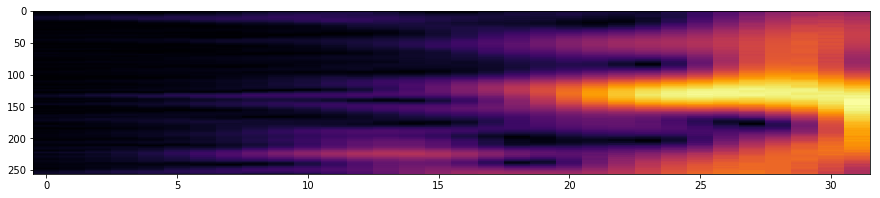

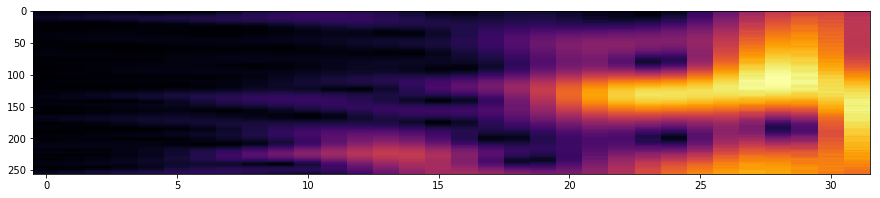

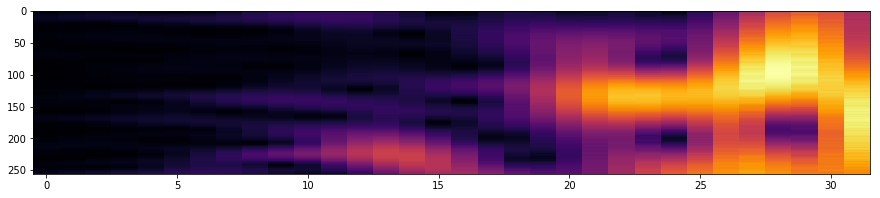

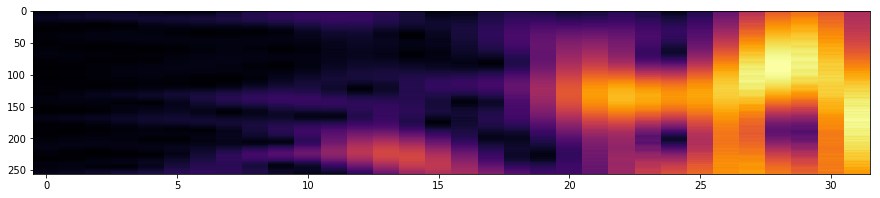

In [822]:
start = time.time()

context_size = int(params['context']*params['fs'])
features_cwt = np.zeros((batch_size,context_size,32,4))
fb_array = [0.5, 1, 1.5, 2]
context_start = int(params['factor_border']*params['context']*params['fs']/2)
context_end = context_start + context_size

# CMorlet
J0 = 2.5 # Initial octave
J = 3 # Number of octaves
Q = 8 # Number of scales per octave
scales = np.power(2, np.arange(J0*Q, J0*Q + 2**np.ceil(np.log2(J*Q)))/Q ) # <-- need to design this yet!
#print(len(scales))
#print(scales)
w = pywt.ContinuousWavelet('cmor')
w.center_frequency = 1
    
for i in range(batch_size):
    for j in range(4):
        fb = fb_array[j]
        w.bandwidth_frequency = fb
        coef, freqs = pywt.cwt(features[i,:], scales, w, 1/params['fs'])
        abs_coef = np.abs(coef[:, context_start:context_end])
        features_cwt[i, :, :, j] = abs_coef.T
#print(freqs)
print('Total Time: ' + str(time.time() - start) + ' [s]')
print('CWT Features: ',features_cwt.shape)

# Show a single example
example = 0
for chan in range(4):
    plt.figure(figsize=(15, 3))
    plt.imshow(features_cwt[example,:,:,chan], interpolation='nearest', cmap=cm.inferno, aspect='auto')
    plt.show()